# An Analysis of Magic: The Gathering's Creatures
Welcome to Magic: The Gathering, a trading card game produced by Wizards of the Coast where each player pretends to be a wizard casting spells and summoning creatures to reduce their opponent's life points from 20 to 0. This game has been out since 1993, and has changed dramatically since then, with the game increasing in power level and complexity over its 30 years of existence. 

## Vocabulary
Throughout the analysis I will use several Magic: the Gathering specific terms. While it is not necessary to have played magic to understand this analysis, the following definition will certainly be helpful. 

  1. Mana: The elemental magic used to cast spells, which is generated from land cards. Each card has its own mana cost, which denotes the amount and type of mana that it requires. There are five types of mana: green (G), white (W), black (B), blue (U), and red (R), each with their own types of spells they like to cast. "CMC" refers to "Converted Mana Cost", or how much total mana it costs to cast the spell. For example, the mana cost of the card below would be 4GG, or 4 of any mana and 2 green mana.
  2. Set: Magic cards are released periodically in groups called "sets" which contain a few hundred magic cards each. The set of the card below is M21.
  3. Type: Each card has a different type; for the purpose of this analysis, we will be focusing on creatures. The card below is a creature.
  4. Creature: Creatures represent minions you can summon to help you fight your opponent. Each creature has a mana cost, a power (its strength), a toughness (its health), a few types (like Human, Elf, Dragon, etc.), and its abilities. A creature with power X and toughness Y is called as "an X/Y creature". The creature below is a 6/6 Dinosar.
  5. Keyword: Some abilities of creatures are common enough across sets that they get their own keyword. This is just an easy way for players to denote some abilities. The card below has trample.
  6. Ability: Most creatures (not all!) have abilities that can be activated or are always in effect. Some creatures have no abilities, which are called vanilla creatures; some creatures only have keyworded abilities, which are called "french vanilla" creatures. The card below does not have one of these; it is french vanilla.
  7. Name: Each card has a unique name. The name of the card below is colossal dreadmaw.
  
  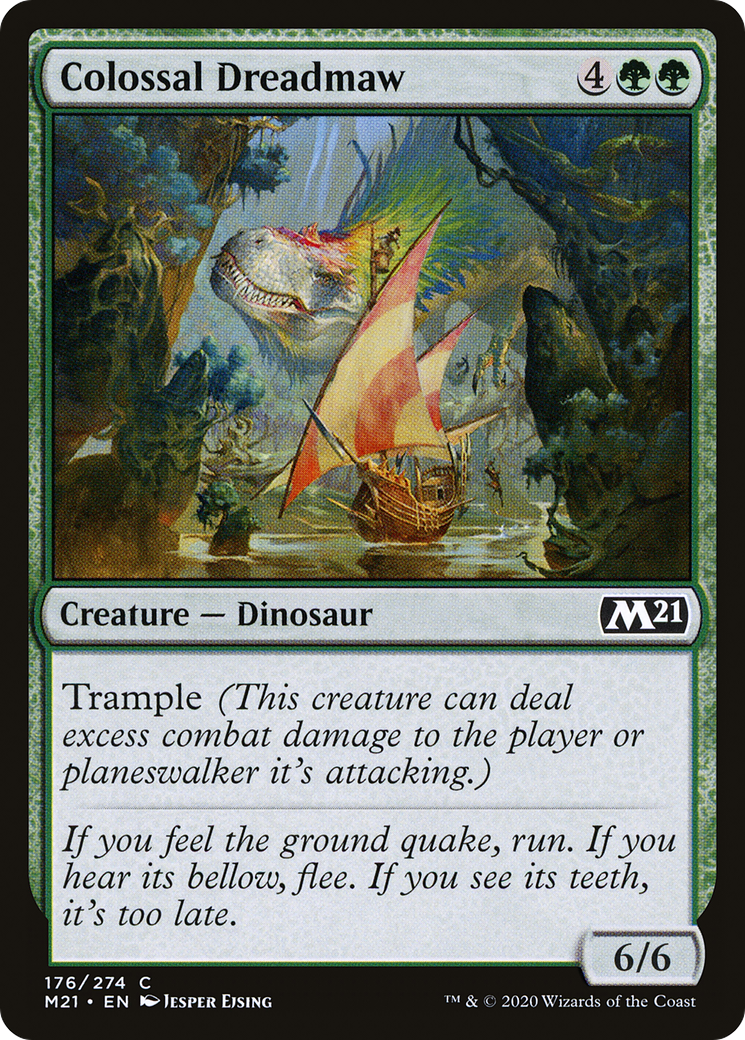
  
Our goal today is to take a look at the mana costs of the creatures of Magic, and see if we can build a model to predict these mana costs based on the other statistics of the card. We will then see if creatures have become more aggressively costed over time (meaning that the same stats are less mana to cast), a phenomenon known a "power creep" by the Magic community.

Here we import all necessary modules for the project.

In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import re
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Data Cleaning

The data we will use is from [scryfall](https://scryfall.com/), a community-ran magic the gathering site. Scryfall's data is often more reliable and accurate than the data that Wizards produces, and it is also freely available for download through their API. This data contains every single card in Magic's history that was printed in English - 78,242 card objects. However, many of these objects are extraneous and would hurt our data analysis. For the next section, I will prune down these cards to exclude reprinted cards, illegal cards, joke cards, and many other types of cards that have been created over the years.

In [2]:
URL = "https://data.scryfall.io/default-cards/default-cards-20221212220657.json"
full_scryfall_df = pd.DataFrame(json.loads(requests.get(URL).text))
full_scryfall_df.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,tcgplayer_etched_id,attraction_lights,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,flavor_name,variation_of
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,[],NaN,NaN,98659.0,NaN,Spirit,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,[435231],65170.0,65171.0,145764.0,301766.0,Siren Lookout,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,[1278],NaN,NaN,1623.0,5664.0,Web,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataframe also comes with 84 columns, many of which we do not need. I will remove all columns except for the useful ones in determining a card's qualities, and in determining whether we want to analyze the card or not.

In [3]:
df = full_scryfall_df[['name',                       # the name of the card - not technically necessary but helpful for debugging
                       'mana_cost',                  # what type of mana the card costs to summon
                       'cmc',                        # how much mana the card costs
                       'type_line',                  # the type of the card (creature, sorcery, etc)
                       'oracle_text',                # what the card does
                       'power', 'toughness',         # the strength of the card if it's a creature
                       'colors', 'color_identity',   # more info on what type of mana the card costs
                       'keywords',                   # the keywords on the card (more on this later)
                       'set', 'released_at',         # when the card was released
                       'rarity',                     # how much the card was printed
                       'games',                      # games tells if it is legal online or in paper (we exclude online-only cards)
                       'legalities']]                # which formats the card is legal in

First, we will remove online-only cards. Wizards of the Coast released a program called Magic Arena, and to promote it they released cards that were only legal for that program. However, these cards were not created with the balance of the paper format in mind, and reference random effects and things only possible online. Therefore, I am excluding them from this analysis.

In [4]:
df = df[df['games'].apply(lambda i: 'paper' in i)]

Next, we will remove all cards that are in there multiple times (e.g. they were printed in multiple sets). Wizards does this sometimes to bring back fan favorite cards or to have some basic cards that always work well. 

In [5]:
df = df.sort_values(by=['released_at', 'name'])
df = df.drop_duplicates(subset=['name'])

Some cards are illegal to play for power-level reasons (too strong for the format); however, we can still analyze these. The "not legal" designation means cards that are literally unplayable: they are printed alongside magic cards, but just say promotional text or act as other game pieces. Tokens are one such piece; some cards create tokens, but you can't put the actual token cards in your deck. However, Scryfall treats all of these as "card objects" and puts them in.

In [6]:
def legal(legalities):
    v = legalities.values()
    if len(set(v)) == 1 and "not_legal" in v:
        return False
    return True

df = df[df['legalities'].apply(legal)]
df = df[~df["type_line"].str.contains("Token", na=False)] # remove tokens

Finally, some cards were designed as jokes by the Wizards designers in sets called "unsets". These cards, like the online cards, aren't tuned for interacting with any other cards, and so I will exclude them from this dataset.

In [7]:
unsets = ['unglued', 'unhinged', 'unstable', 'unsanctioned', 'unfinity']
sets = json.loads(requests.get("https://api.scryfall.com/sets").text)
for s in sets["data"]:
    if s['name'].lower() in unsets:
        df = df[~df["set"].str.contains(s['code'])]

## Data Processing

Some of these columns aren't qute in the format we'd like them to be in, so I'm going to change them to be friendlier to numerical algorithms, and add some useful columns. 

The actual release date isn't particularly mathematically helpful, so I will change it to the number of years since the first set (known as Alpha) was released, on August 5th 1993. 

In [8]:
df = df.dropna() # drop NAN values

alpha_release_date = dt.datetime(1993, 8, 5)
df['released_at'] = df['released_at'].apply(lambda i: (dt.datetime.strptime(i, '%Y-%m-%d').year - alpha_release_date.year))

One helpful factor in our analysis will show how deep into a color a card is. Wizards often makes cards cost more mana of a certain color if they want to nerf the card somewhat; e.g. if they want to make a more powerful creature at the same mana cost. So, counting the amount of colored mana required to cast the spell will be a useful factor in the analysis. A similar factor is the number of different colors: a spell that requires multiple types of mana is considered more difficult to cast, and so may have a lower mana cost.

In [9]:
df["num_colored_pips"] = df["mana_cost"].apply(lambda mana_cost: len(re.findall("\{[^\d]\}", str(mana_cost))))
df["num_colors"] = df["colors"].apply(len)

Finally, for this analysis we will just be looking at creatures. Let's also make those CMC, power, and toughness values integers to be easier to work with. If they aren't underlylingly integers (some have X, \*, or ?, or nothing), we wil ignore those as they are difficult to work with without also parsing the ability text.

In [10]:
df = df[df["type_line"].str.contains("Creature", na=False)]

def make_int(i):
    try:
        return int(i)
    except ValueError:
        return np.nan

for i in ['cmc', 'power', 'toughness']:
    df[i] = df[i].apply(make_int).astype('Int64')#
df = df.dropna()

Let's take a look!

In [11]:
df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
32371,Air Elemental,{3}{U}{U},5,Creature — Elemental,Flying,4,4,[U],[U],[Flying],lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
5420,Benalish Hero,{W},1,Creature — Human Soldier,"Banding (Any creatures with banding, and up to...",1,1,[W],[W],[Banding],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1
26263,Birds of Paradise,{G},1,Creature — Bird,Flying\n{T}: Add one mana of any color.,0,1,[G],[G],[Flying],lea,0,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1
59195,Black Knight,{B}{B},2,Creature — Human Knight,First strike (This creature deals combat damag...,2,2,[B],[B],"[First strike, Protection]",lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
31516,Bog Wraith,{3}{B},4,Creature — Wraith,Swampwalk (This creature can't be blocked as l...,3,3,[B],[B],"[Landwalk, Swampwalk]",lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


As you can see, we've now got the important parts of a card, and the cards are sorted conveniently by their release date. We are now looking at the first magic cards ever released. How strong were they? Let's find out!

## Vanilla Creature Analysis
A vanilla creature is a creature with no text whatsoever - just stats! The "classic" vanilla creature is the Grizzly Bears, a 2/2 for 2 mana in green.

In [12]:
df[df["name"].str.contains("Grizzly Bears")]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
63158,Grizzly Bears,{1}{G},2,Creature — Bear,,2,2,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


However, not all creatures are created equally. For example, the Coral Eel has the same mana cost, but only 1 toughness. The difference? It's in blue!

In [13]:
df[df["name"].str.contains("Coral Eel")]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
16522,Coral Eel,{1}{U},2,Creature — Fish,,2,1,[U],[U],[],por,4,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


Clearly, some colors are better at producing creatures than other colors. But how much better? Let's start with vanilla creatures, since we know none of their abilities is influencing their mana cost. Therefore, we can just get a look at how much each point of power and toughness is costing, mana-wise.

In [14]:
vanilla_df = df[df["oracle_text"] == ""]
vanilla_df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
58740,Craw Wurm,{4}{G}{G},6,Creature — Wurm,,6,4,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
54563,Earth Elemental,{3}{R}{R},5,Creature — Elemental,,4,5,[R],[R],[],lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
66828,Fire Elemental,{3}{R}{R},5,Creature — Elemental,,5,4,[R],[R],[],lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
35350,Gray Ogre,{2}{R},3,Creature — Ogre,,2,2,[R],[R],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1
63158,Grizzly Bears,{1}{G},2,Creature — Bear,,2,2,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


Only 2.57% of creatures ever printed have been vanilla, so this analysis won't tell us much about a lot of creatures. However, it gives us a base from which to peform similar analyses on more complicated creatures.

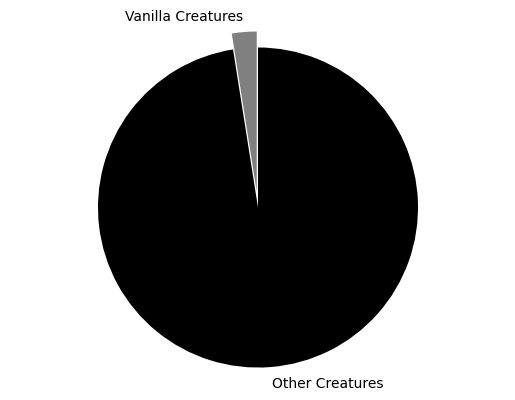

In [42]:
plt.pie([len(vanilla_df.index), len(df.index)], 
        explode=(0.1, 0), 
        labels=['Vanilla Creatures', 'Other Creatures'], 
        colors=['gray', 'black'],
        startangle=90)
plt.axis('equal') 
plt.show()

Now we can look at plots of mana cost, power, and toughness. We can see from this plot that the vast majority of vanilla creatures are very small, with less than 4 power and toughness. Generally, when a creature has larger power and toughness, it is a more powerful creature in the Magic storyline, and the designers want to make the card more exciting. So, they give it abilities, which means it doesn't show up in this plot.

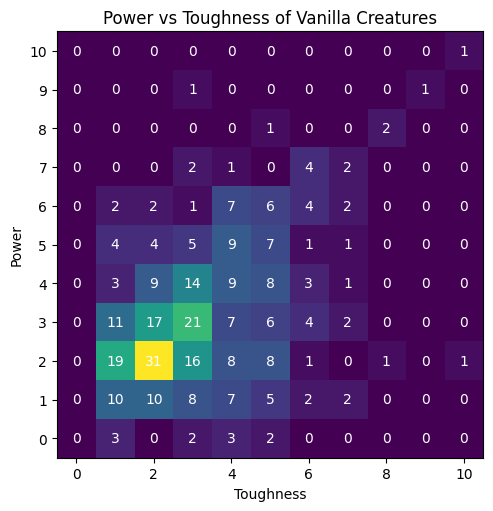

In [38]:
mp, mt = max(vanilla_df['power']) + 1, max(vanilla_df['toughness']) + 1
data = np.zeros((mp, mt))

fig, ax = plt.subplots()

for power in range(mp):
    for toughness in range(mt):
        count = len(vanilla_df[(vanilla_df['power'] == power) & (vanilla_df['toughness'] == toughness)]['cmc'].values)
        data[mp - power - 1][toughness] = count
        
        text = ax.text(toughness, mp - power - 1, count,
                       ha="center", va="center", color="w")

ax.set_yticks(np.arange(mp), labels=list(range(mp))[::-1]) # invert power so that 0/0 is the bottom left corner

im = ax.imshow(data)
fig.tight_layout()
plt.xlabel("Toughness")
plt.ylabel("Power")
plt.title("Power vs Toughness of Vanilla Creatures")
plt.show()

Magic cards are distributed in packs, and so they have rarities which determine how often they show up in packs. In a 15-card pack, there are 11 commons, 3 uncommons, and only 1 rare, so getting a vanilla creature as your rare would not be good for business. Therefore, Magic doesn't print very many rare vanilla creature cards, but they do print some.

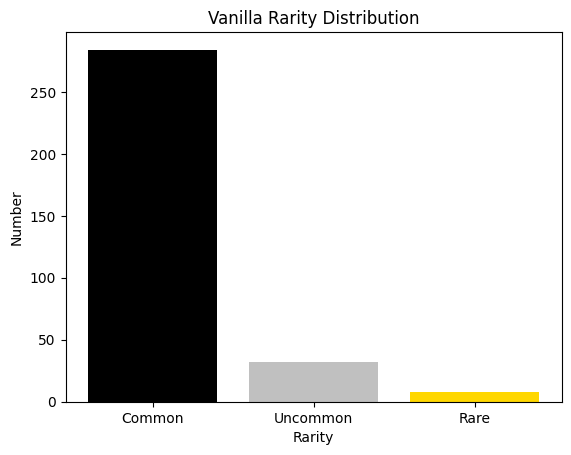

In [17]:
plt.bar(['Common', 'Uncommon', 'Rare'], vanilla_df['rarity'].value_counts(), color=['black', 'silver', 'gold'])
plt.title("Vanilla Rarity Distribution")
plt.xlabel("Rarity")
plt.ylabel("Number")
plt.show()

Now let's try to predict the mana cost of the creature based on the data we have. First, let's drop all unnecessary data and get just the good stuff into a `data_df`. This will contain all the variables with which we will predict Converted Mana Cost.

Our goal is to predict the Converted Mana Cost of a creature based just on its vanilla stats. These stats include its power, toughness, color, rarity, release date, number of colored pips, and number of colors. My predictions are as follows:

 1. A point of power will cost more than a point of toughness, as there are many cheap creatures such as Walls which are good at defending but poor at attacking.
 2. The color will have some influence; Green creatures will be the cheapest, and probably Blue creatures will incur some mana cost penalty, but I'm not sure where the other colors will be in between.
 3. Rarity will have a large influence, especially on vanilla creatures; rare vanilla creatures will be much less expensive than common ones. 
 4. Release date will have some influence, as newer cards are generally considered more powerful than older cards.
 5. Number of colored pips and number of colors may not matter much for vanilla creatures as most vanilla creatures are one color and very low colored pips. However, they might come up with a bigger effect in later analyses.

In [18]:
data_df = vanilla_df.drop(columns=["mana_cost", "type_line", "oracle_text", "color_identity", "keywords", "set", "games", "legalities"])
data_df.head()

,name,cmc,power,toughness,colors,released_at,rarity,num_colored_pips,num_colors
58740,Craw Wurm,6,6,4,[G],0,common,2,1
54563,Earth Elemental,5,4,5,[R],0,uncommon,2,1
66828,Fire Elemental,5,5,4,[R],0,uncommon,2,1
35350,Gray Ogre,3,2,2,[R],0,common,1,1
63158,Grizzly Bears,2,2,2,[G],0,common,1,1


We still have some categorical variables. A linear regression cannot handle these, so I wrote a custom function that will expand them and then one-hot encode them. One-hot encoding means that instead of having a single rarity column with values "common" and "uncommon", we now have two rarity columns, "rarity_common" and "rarity_uncommon", which contain integer values which are 0 if the card is rare and 1 if the card is uncommon. We will do the same thing for colors -- note that a card can have multiple colors, so there could be multiple `colors_` columns that have a 1 in them for a given card.

To learn more about one-hot encoding, visit [this link](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). 

This will give us a total of 11 variables for our regression.

In [19]:
def dummy_list(data_df, one_hot_df, column, predicate=lambda i, j: i == j):
    x = set(data_df.explode(column)[column].values) # get all values from the column
    if np.nan in x: # remove NaNs that might be in there
        x.remove(np.nan)
    
    for i in x: # make the new one-hot column
        one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: int(predicate(i, j)))

one_hot_df = data_df.drop(columns=['colors', 'rarity'])
dummy_list(data_df, one_hot_df, 'colors', predicate=lambda i, j: i in j)
dummy_list(data_df, one_hot_df, 'rarity')
one_hot_df.head()

,name,cmc,power,toughness,released_at,num_colored_pips,num_colors,colors_U,colors_R,colors_W,colors_G,colors_B,rarity_rare,rarity_uncommon,rarity_common
58740,Craw Wurm,6,6,4,0,2,1,0,0,0,1,0,0,0,1
54563,Earth Elemental,5,4,5,0,2,1,0,1,0,0,0,0,1,0
66828,Fire Elemental,5,5,4,0,2,1,0,1,0,0,0,0,1,0
35350,Gray Ogre,3,2,2,0,1,1,0,1,0,0,0,0,0,1
63158,Grizzly Bears,2,2,2,0,1,1,0,0,0,1,0,0,0,1


We will now perform the linear regression. The basic idea behind linear regression is that we are trying to find the best way to predict the target variable (CMC, or `y` in the below code) using a linear combination of the other variables in our dataset (the other columns in `one_hot_df`, or `X` in the below code).

First, we split the dataframe to get the variables and the expected output:

In [20]:
X = one_hot_df.drop(columns=['name', 'cmc'])
y = one_hot_df['cmc']

Linear regressions also contain a term known as a constant or an intercept; this is equivalent to the intercept (b) in the typical formula for a line `y = mx + b`, where `mx` is actually $$\sum_{i=1}^n m_ix_i$$ for each variable x and coefficient m, creating a linear combination. To add the constant, we use the `add_constant` function, which just adds a column of 1's to x.

In [21]:
X = sm.add_constant(X)

Finally, we run the Least Squares algorithm. This tries to find the linear combination "regression line" that fits the data the best, where "the best" means the sum of the squares of all the errors is minimized. You can learn more about the intuition behind least squares regression [here](https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-regression/the-method-of-least-squares.html).  

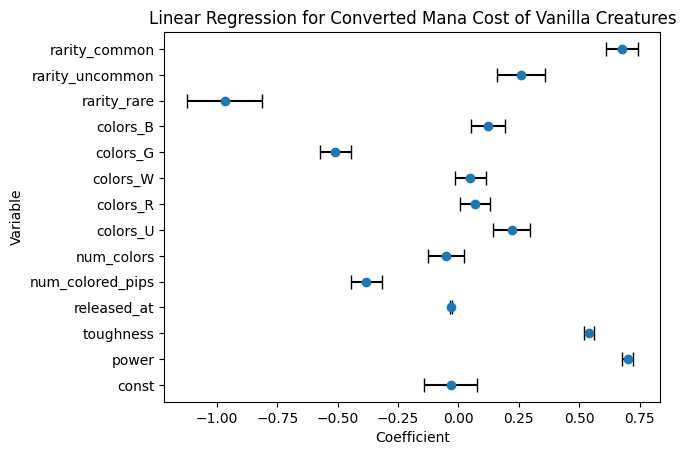

In [22]:
# Run statsmodel's OLS (Generalized Least Squares) model, making sure it's on integers
model = sm.OLS(np.asarray(y, dtype=int), 
               np.asarray(X, dtype=int)).fit()

# Plot the coefficients, with error bars
plt.errorbar(model.params, X.columns, xerr=model.bse, fmt='o', ecolor='black', capsize=5)
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.title("Linear Regression for Converted Mana Cost of Vanilla Creatures")
plt.show()

There are several interesting results to discuss. Firstly, the rarity was as expected; commons are overcosted, while rares are expected to cost one full mana less (which is a large amount in magic). There aren't very many rare vanilla creatures, leading to the wide error bars. 

Secondly, green creatures are expected to cost half a mana less, with the other colors roughly around the same place. This makes sense, as green mana is all about creatures; blue or black has the biggest expected mana cost increase.

A point of power is also expected to be worth more than a point of toughness; this was as I expected, as again cheap defenders are more plentiful than cheap attackers.

The number of colors did not have much effect, but what intrigued me the most was that `released_at` had almost no effect. One of the biggest complaints about magic is that cards increase in power over time, making older cards unplayable; however, it seems that the Grizzly Bears from Alpha is still pretty playable! Let's see.

To check the expected mana value of a card, we can take each value from its row and multiply it by the coefficient from the linear regression, then add the intercept:

In [23]:
def expected_mana_cost(row):
    return sum(row * model.params[1:]) + model.params[0]

one_hot_df['expected_mana_value'] = one_hot_df.drop(columns=['name', 'cmc']).apply(expected_mana_cost, axis=1)
one_hot_df

,name,cmc,power,toughness,released_at,num_colored_pips,num_colors,colors_U,colors_R,colors_W,colors_G,colors_B,rarity_rare,rarity_uncommon,rarity_common,expected_mana_value
58740,Craw Wurm,6,6,4,0,2,1,0,0,0,1,0,0,0,1,5.690056
54563,Earth Elemental,5,4,5,0,2,1,0,1,0,0,0,0,1,0,4.993144
66828,Fire Elemental,5,5,4,0,2,1,0,1,0,0,0,0,1,0,5.151129
35350,Gray Ogre,3,2,2,0,1,1,0,1,0,0,0,0,0,1,2.764881
63158,Grizzly Bears,2,2,2,0,1,1,0,0,0,1,0,0,0,1,2.186319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11291,Highborn Vampire,4,4,3,27,1,1,0,0,0,0,1,0,0,1,3.967672
73427,Murasa Brute,3,3,3,27,1,1,0,0,0,1,0,0,0,1,2.636510
22628,Grizzled Outrider,5,5,5,28,1,1,0,0,0,1,0,0,0,1,5.092426
22694,Ageless Guardian,2,1,4,28,1,1,0,0,1,0,0,0,0,1,2.308297


We can see that it got fairly close on some of these old cards. Looking at the newest cards, we can see that Gray Ogre (a 2/2 for 3 in Red) is much more overcosted than the newer version, a 2/4 for 3 in Green. so there certainly is some power creep, but it is not as strong as some people say. Or is it?

## French Vanilla Analysis
Now we will look at slightly more interesting creatures: creatures with keywords. While these creatures still don't have ability text, they can actually have useful keywords on them that help during combat, help to protect the creature, or anything in between. I will provide examples of some of the most common abilities after a bit of data processing.

To find keywords, scryfall helpfully has a column called `keywords`. However, there are some newer cards that contain words called "flavor words", which we don't want to count here but scryfall counts them as keywords. Therefore, I am excluding them from the analysis; you can read some logic behind there introduction [here](https://magic.wizards.com/en/news/feature/adventures-forgotten-realms-mechanics-2021-07-02). 

In [24]:
keywords = set()
for i, row in df.iterrows():
    if row['set'] not in ['afr', '40k', 'clb', 'sld']:
        # normal set
        keywords = keywords.union(row['keywords'])
    else:
        # ignore flavor words by ignoring keywords with spaces
        keywords = keywords.union([kw for kw in row['keywords'] if ' ' not in kw]) 
        
keyword_soup = ' '.join(keywords).lower() # easy way to convert everything to lowercase

First, let's write some code to extract the relevant text from a magic card. Magic cards can have lots of things in their oracle text; for example, text in parentheses that reminds the player how a certain ability works. Additionally, some abilities have arguments; for example, Ward is an ability that comes with an associated cost, while Protection comes with a description of what it protects from. Because these aren't part of the keyword, they won't be in our `keyword_soup` variable, and so we have to process them out.

In [25]:
removes = [r'(\(.*?\))', # remove parentheses (reminder text)
           r'(\{.*?\})', # remove mana costs for certain abilities (outlast, etc.)
           r'(—[^ ][^\n]*)', # remove ward costs
           r'[Pp]rotection(?! F)([^\n]*)', # remove protection type
           r'(\d*)', # remove numbers for certain abilities (rampage, etc.)
           r'Prototype([^\n]*)'] # remove prototype costs

def extract_ability_text(row):
    text = row['oracle_text']

    if text is np.nan or text == '':
        return ''
    
    for r in removes:
        if m := re.search(r, text):
            start, end = m.span(1) # remove first capturing group
            text = text[:start] + text[end:]
        
    text = text.replace(',', '').replace(';', '')
    text = text.lower()
    text = text.strip()

    return text

df['ability_text'] = df.apply(extract_ability_text, axis=1)

Now we're prepared for our `is_french_vanilla` function. This function will take a row and determine if it's french vanilla by extracting the relevant text and making sure that every token in the relevant text is a keyword. If there is a non-keyword token, it is not french vanilla (remember, a french vanilla creature *only has keywords* as its abilities). 

In [26]:
def is_french_vanilla(row):
    text = row['ability_text']

    for i in text.split():
        if i not in keyword_soup: # check that every word is a kewyord
                                  # note that keywords are never in front of a period or any punctuation other 
                                  # than , or ; so we don't need to do any complicated tokenization
            return False

    return True
df['is_french_vanilla'] = df.apply(is_french_vanilla, axis=1)

Making the dataframe of only french vanilla creatures is quite easy; simply apply our `is_french_vanilla` to each row, then take only the rows that have `True` in that column.

In [27]:
french_vanilla_df = df[df['is_french_vanilla']]
french_vanilla_df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors,ability_text,is_french_vanilla
32371,Air Elemental,{3}{U}{U},5,Creature — Elemental,Flying,4,4,[U],[U],[Flying],lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1,flying,True
5420,Benalish Hero,{W},1,Creature — Human Soldier,"Banding (Any creatures with banding, and up to...",1,1,[W],[W],[Banding],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1,banding,True
59195,Black Knight,{B}{B},2,Creature — Human Knight,First strike (This creature deals combat damag...,2,2,[B],[B],"[First strike, Protection]",lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1,first strike \nprotection,True
31516,Bog Wraith,{3}{B},4,Creature — Wraith,Swampwalk (This creature can't be blocked as l...,3,3,[B],[B],"[Landwalk, Swampwalk]",lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1,swampwalk,True
58740,Craw Wurm,{4}{G}{G},6,Creature — Wurm,,6,4,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1,,True


There is now a new rarity, mythic rare! Mythic rare is a rarity in Magic that is six times rarer than rare. Most mythics are extremely powerful and so have more abilities than just keywords, but there have been a few french vanilla mythics printed:

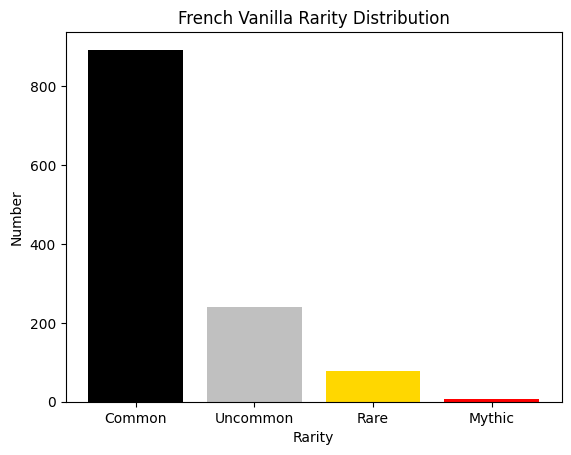

In [28]:
plt.bar(['Common', 'Uncommon', 'Rare', 'Mythic'], 
        french_vanilla_df['rarity'].value_counts(), 
        color=['black', 'silver', 'gold', 'red'])
plt.title("French Vanilla Rarity Distribution")
plt.xlabel("Rarity")
plt.ylabel("Number")
plt.show()

Now we can make a similar `data_df` to before, except now we are including the `keywords` column. We can do the same process to one-hot encode the dataframe. Notice there is a new rarity column, `rarity_mythic`. 

In [29]:
fv_data_df = french_vanilla_df.drop(columns=['mana_cost', 'type_line', 'color_identity', 'set', 'is_french_vanilla', 'games', 'legalities'])
fv_one_hot_df = fv_data_df.drop(columns=['colors', 'oracle_text', 'keywords', 'rarity'])
dummy_list(fv_data_df, fv_one_hot_df, 'colors', predicate=lambda i, j: i in j)
dummy_list(fv_data_df, fv_one_hot_df, 'rarity')
fv_one_hot_df.head()

,name,cmc,power,toughness,released_at,num_colored_pips,num_colors,ability_text,colors_U,colors_R,colors_W,colors_G,colors_B,rarity_rare,rarity_uncommon,rarity_common,rarity_mythic
32371,Air Elemental,5,4,4,0,2,1,flying,1,0,0,0,0,0,1,0,0
5420,Benalish Hero,1,1,1,0,1,1,banding,0,0,1,0,0,0,0,1,0
59195,Black Knight,2,2,2,0,2,1,first strike \nprotection,0,0,0,0,1,0,1,0,0
31516,Bog Wraith,4,3,3,0,1,1,swampwalk,0,0,0,0,1,0,1,0,0
58740,Craw Wurm,6,6,4,0,2,1,,0,0,0,1,0,0,0,1,0


For keywords, we have to do something slightly different. It is possible for one card to have multiple instances of the same keyword (only 7 cards ever do, but potentially more could in the future). So, we have to count the instances of each keyword. 

In [30]:
keyword_counts = {}

for keyword in keywords:
    counts = fv_data_df.apply(lambda row: row['ability_text'].count(keyword.lower()), axis=1)
    if sum(counts) > 0: # some keywords never appear on french vanilla creatures
        keyword_counts[keyword] = sum(counts)
        fv_one_hot_df[f'keywords_{keyword}'] = counts

Let's see the regression results!

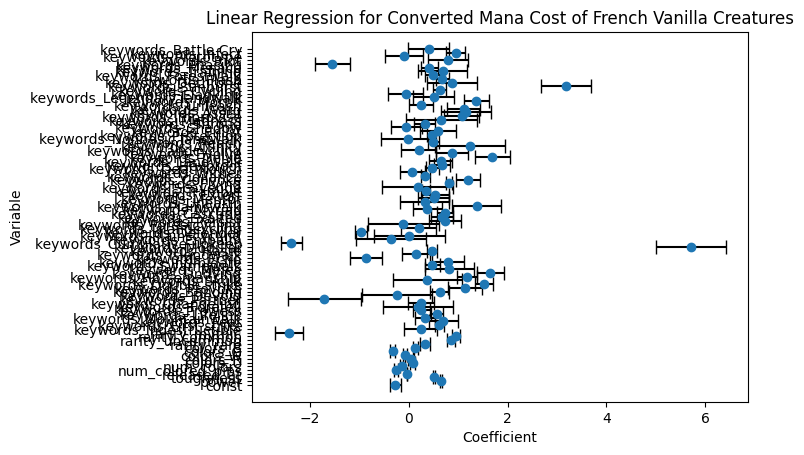

In [31]:
X = fv_one_hot_df.drop(columns=['name', 'cmc', 'ability_text'])
X = sm.add_constant(X)
y = fv_one_hot_df['cmc']

model = sm.OLS(np.asarray(y, dtype=int), 
               np.asarray(X, dtype=int)).fit()

plt.errorbar(model.params, X.columns, xerr=model.bse, fmt='o', ecolor='black', capsize=5)
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.title("Linear Regression for Converted Mana Cost of French Vanilla Creatures")
plt.show()

In [32]:
fv_one_hot_df['expected_mana_value'] = fv_one_hot_df.drop(columns=['name', 'cmc', 'ability_text']).apply(expected_mana_cost, axis=1)
fv_one_hot_df['power_level'] = fv_one_hot_df['expected_mana_value'] - fv_one_hot_df['cmc']
fv_one_hot_df.head()

,name,cmc,power,toughness,released_at,num_colored_pips,num_colors,ability_text,colors_U,colors_R,...,keywords_Forestwalk,keywords_Training,keywords_Menace,keywords_Phasing,keywords_Riot,keywords_Prototype,keywords_Infect,keywords_Battle Cry,expected_mana_value,power_level
32371,Air Elemental,5,4,4,0,2,1,flying,1,0,...,0,0,0,0,0,0,0,0,5.514574,0.514574
5420,Benalish Hero,1,1,1,0,1,1,banding,0,0,...,0,0,0,0,0,0,0,0,2.038806,1.038806
59195,Black Knight,2,2,2,0,2,1,first strike \nprotection,0,0,...,0,0,0,0,0,0,0,0,3.503824,1.503824
31516,Bog Wraith,4,3,3,0,1,1,swampwalk,0,0,...,0,0,0,0,0,0,0,0,4.321527,0.321527
58740,Craw Wurm,6,6,4,0,2,1,,0,0,...,0,0,0,0,0,0,0,0,5.718505,-0.281495


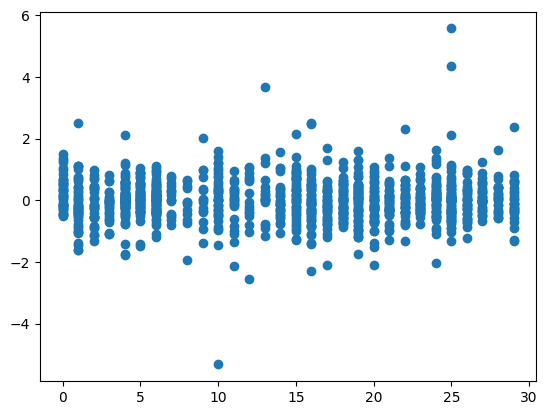

In [36]:
plt.scatter(fv_one_hot_df['released_at'], fv_one_hot_df['power_level'])

# Conclusions